In [ ]:
# Instalação das bibliotecas necessárias (descomente e rode no seu notebook, se ainda não as tiver)
!pip install yfinance pycoingecko pandas numpy matplotlib seaborn

Buscando dados do Yahoo Finance...
  Dados para Dólar (USD/BRL) (USDBRL=X) obtidos.
  Dados para Euro (EUR/BRL) (EURBRL=X) obtidos.
  Dados para Libra (GBP/BRL) (GBPBRL=X) obtidos.
  Dados para Ouro (GC=F) (GC=F) obtidos.
  Dados para SGOV ETF (SGOV) obtidos.
  Dados para IAU ETF (IAU) obtidos.
  Dados para QTUM ETF (QTUM) obtidos.

Buscando dados do CoinGecko para bitcoin...


/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-2252059669.py:46: FutureWarning: YF.download() has changed argument auto_adjust d

  Dados para Bitcoin obtidos via CoinGecko.

Pré-visualização das cotações combinadas (últimas 5 linhas):
            USDBRL=X  EURBRL=X  GBPBRL=X         GC=F        SGOV        IAU  \
Date                                                                           
2025-07-27    5.5200  6.480881  7.457142  3334.000000  100.660004  62.910000   
2025-07-28    5.5652  6.535948  7.478700  3309.100098  100.690002  62.520000   
2025-07-29    5.5868  6.472492  7.451565  3323.399902  100.690002  62.689999   
2025-07-30    5.5732  6.430868  7.434944  3323.399902  100.690002  62.689999   
2025-07-30    5.5732  6.430868  7.434944  3323.399902  100.690002  62.689999   

                 QTUM        Bitcoin  
Date                                  
2025-07-27  93.800003  656397.669325  
2025-07-28  93.760002  664743.354946  
2025-07-29  93.440002  659437.852656  
2025-07-30  93.440002  656996.841284  
2025-07-30  93.440002  654922.467642  

Pré-visualização dos retornos diários (últimas 5 linhas):
 

/tmp/ipython-input-2252059669.py:127: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cotacoes_df = cotacoes_df.fillna(method='ffill').fillna(method='bfill')


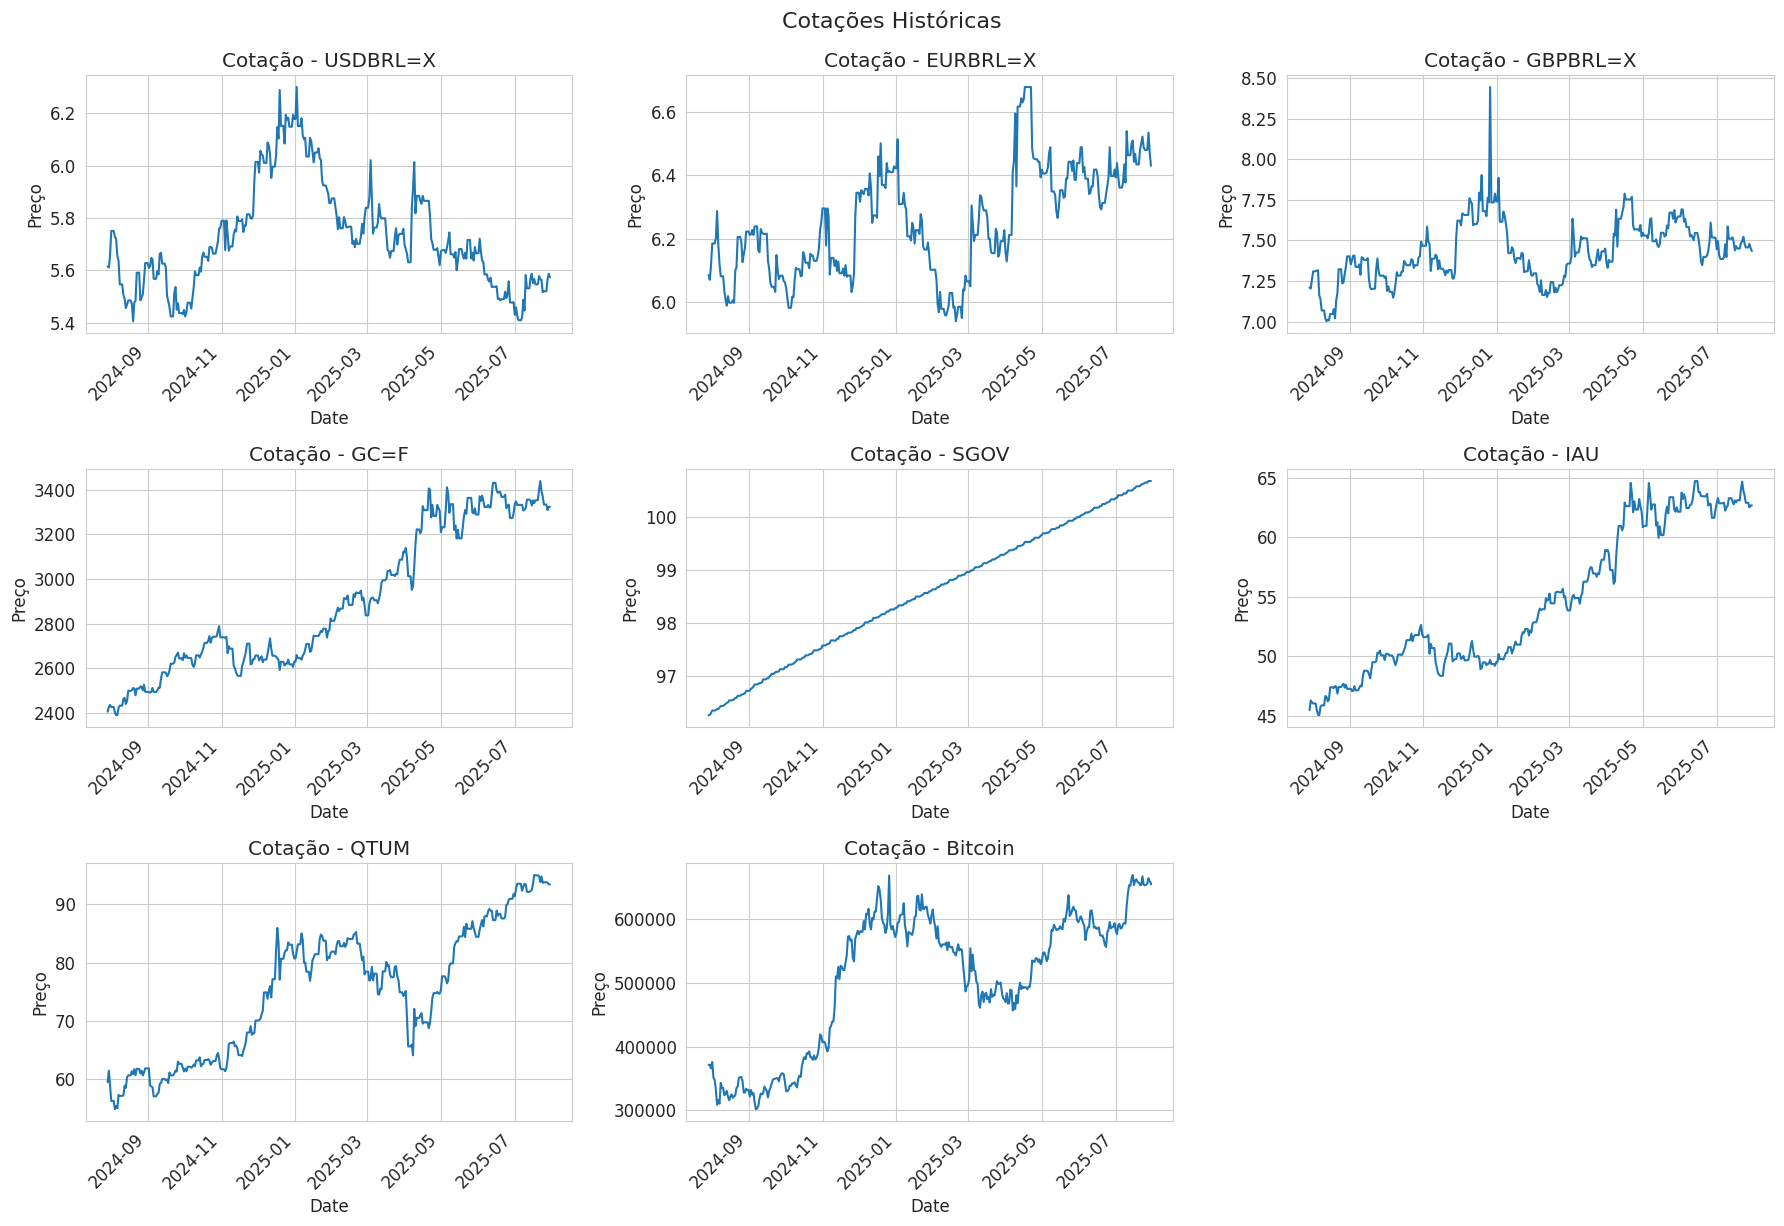


Gerando histogramas dos retornos diários...


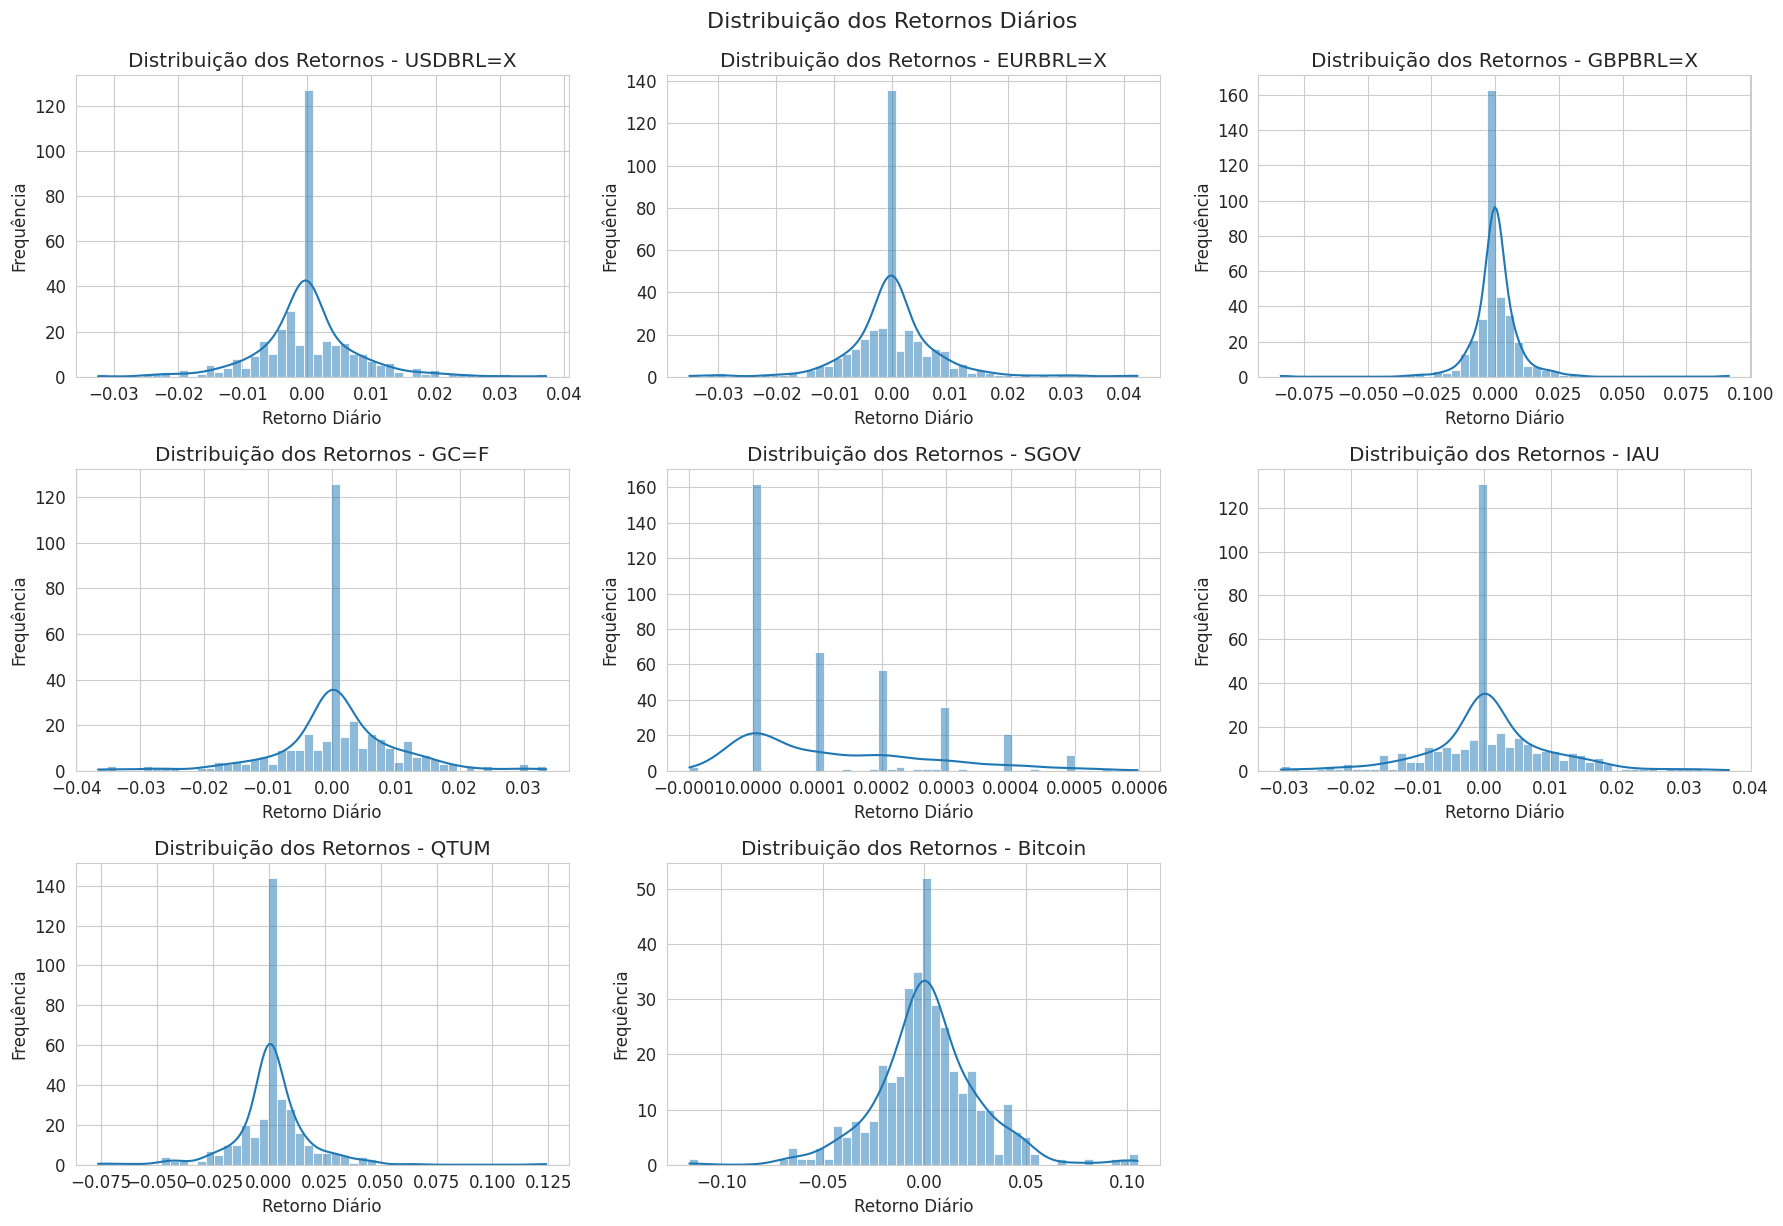


Gerando scatter plot de Risco vs Retorno...


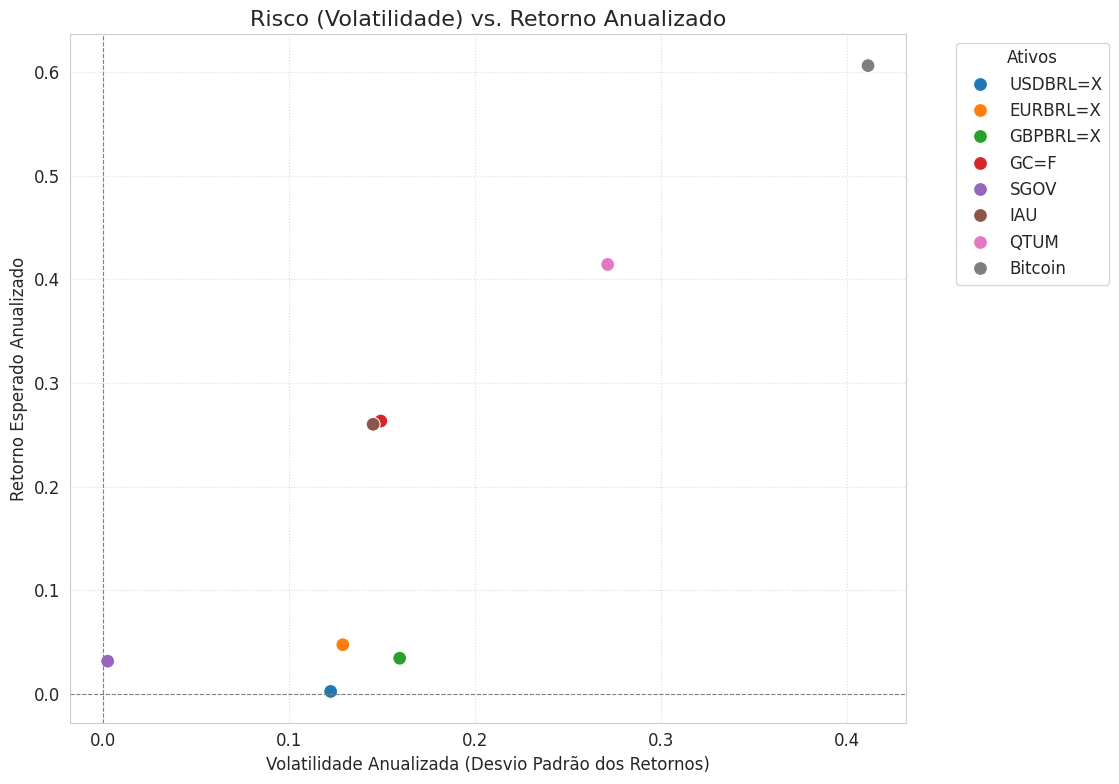


--- Análise Concluída ---


In [ ]:
# Instalação das bibliotecas necessárias
# !pip install yfinance pycoingecko pandas numpy matplotlib seaborn

import yfinance as yf
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

# --- 1. DEFINIÇÃO DOS ATIVOS E PERÍODO ---
ativos_yf = {
    'Dólar (USD/BRL)': 'USDBRL=X',
    'Euro (EUR/BRL)': 'EURBRL=X',
    'Libra (GBP/BRL)': 'GBPBRL=X',
    'Ouro (GC=F)': 'GC=F',
    'SGOV ETF': 'SGOV',
    'IAU ETF': 'IAU',
    'QTUM ETF': 'QTUM'
}
ativo_cg = {'Bitcoin': 'bitcoin'}
id_bitcoin_cg = 'bitcoin'

# Período para análise
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Formato de data
start_date_str_yf = start_date.strftime('%Y-%m-%d')
end_date_str_yf = end_date.strftime('%Y-%m-%d')
days_cg = (end_date - start_date).days

# --- 2. FUNÇÕES PARA BUSCAR DADOS ---

def buscar_dados_yfinance(tickers_dict, start, end):
    dados = {}
    print("Buscando dados do Yahoo Finance...")
    for nome_amigavel, ticker in tickers_dict.items():
        try:
            df = yf.download(ticker, start=start, end=end, progress=False)
            if df is not None and not df.empty:
                if 'Close' in df.columns:
                    dados[nome_amigavel] = df['Close']  # Store the 'Close' Series
                    print(f"  Dados para {nome_amigavel} ({ticker}) obtidos.")
                else:
                    print(f"  Coluna 'Close' não encontrada para {nome_amigavel} ({ticker}).")
            else:
                print(f"  Não foi possível obter dados para {nome_amigavel} ({ticker}).")
        except Exception as e:
            print(f"  Erro ao buscar dados para {nome_amigavel} ({ticker}): {e}")

    if not dados:
        print("Nenhum dado do Yahoo Finance foi obtido.")
        return pd.DataFrame()

    dfs = []
    for nome_amigavel, series in dados.items():
        # Check if 'series' is already a DataFrame
        if isinstance(series, pd.DataFrame):
            # If it's a DataFrame, rename the 'Close' column
            df = series.rename(columns={'Close': nome_amigavel})
        else:
            # If it's a Series, convert it to a DataFrame
            df = series.to_frame(name=nome_amigavel)
        dfs.append(df)

    df_final = pd.concat(dfs, axis=1)
    df_final.index.name = 'Date'  # Set index name to 'Date'
    df_final = df_final.reset_index()

    return df_final


def buscar_dados_coingecko(coin_id, vs_currency='brl', days=365):
    print(f"\nBuscando dados do CoinGecko para {coin_id}...")
    cg = CoinGeckoAPI()
    try:
        historico = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days)
        if 'prices' in historico and historico['prices']:
            df = pd.DataFrame(historico['prices'], columns=['timestamp', 'price'])
            df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.normalize()
            df = df.set_index('date')['price']
            df.name = coin_id.capitalize()
            print(f"  Dados para {coin_id.capitalize()} obtidos via CoinGecko.")
            return df
        else:
            print(f"  Não foi possível obter 'prices' para {coin_id} via CoinGecko.")
            return pd.Series(name=coin_id.capitalize(), dtype=float)
    except Exception as e:
        print(f"  Erro ao buscar dados para {coin_id} via CoinGecko: {e}")
        return pd.Series(name=coin_id.capitalize(), dtype=float)


# --- 3. COLETA E COMBINAÇÃO DOS DADOS ---
dados_yf_df = buscar_dados_yfinance(ativos_yf, start_date_str_yf, end_date_str_yf)
dados_cg_series = buscar_dados_coingecko(id_bitcoin_cg, vs_currency='brl', days=days_cg)

# Combinar os dados
dfs_to_concat = []
if dados_yf_df is not None and not dados_yf_df.empty:
    # Reset index of dados_yf_df before concatenation, avoid using 'Date' as index before concatenation
    # dados_yf_df = dados_yf_df.reset_index()
    dfs_to_concat.append(dados_yf_df)
if dados_cg_series is not None and not dados_cg_series.empty:
    dfs_to_concat.append(dados_cg_series.to_frame())  # Converter Series para DataFrame

if dfs_to_concat:
    # Concatenate dataframes using the common column 'Date' for alignment
    cotacoes_df = pd.merge(dfs_to_concat[0], dfs_to_concat[1], left_on='Date', right_index=True, how='outer')
    # Remove rows with all NaN values after concatenation, use subset to specify columns to check
    cotacoes_df.dropna(how='all', subset=[c for c in cotacoes_df.columns if c != 'Date'], inplace=True)
    # Set 'Date' as index after concatenation and handling NaNs
    cotacoes_df = cotacoes_df.set_index('Date')
else:
    cotacoes_df = pd.DataFrame()
    print("\nNenhum dado de cotação foi obtido de nenhuma fonte. Encerrando o script.")
    exit()

# Tratamento de dados faltantes
if not cotacoes_df.empty:
    cotacoes_df = cotacoes_df.fillna(method='ffill').fillna(method='bfill')
    cotacoes_df.dropna(how='all', axis=0, inplace=True)
    cotacoes_df.dropna(how='all', axis=1, inplace=True)

    if not cotacoes_df.empty:
        print("\nPré-visualização das cotações combinadas (últimas 5 linhas):")
        print(cotacoes_df.tail())
    else:
        print("\nDataFrame de cotações ficou vazio após tratamento de NaNs.")
else:
    print("\nDataFrame de cotações está vazio. Não é possível prosseguir com as análises.")


if not cotacoes_df.empty:
    # --- 4. CÁLCULO DOS RETORNOS DIÁRIOS ---
    retornos_diarios = cotacoes_df.pct_change().dropna()
    if not retornos_diarios.empty:
        print("\nPré-visualização dos retornos diários (últimas 5 linhas):")
        print(retornos_diarios.tail())
    else:
        print("\nDataFrame de retornos diários está vazio.")

    # --- 5. VISUALIZAÇÕES ---
    if not cotacoes_df.empty and not retornos_diarios.empty:
        # 5.1 Gráficos de Linha das Cotações
        print("\nGerando gráficos de linha das cotações...")
        num_ativos = len(cotacoes_df.columns)
        if num_ativos > 0:
            cols_subplot = 3
            rows_subplot = (num_ativos + cols_subplot - 1) // cols_subplot

            fig, axes = plt.subplots(rows_subplot, cols_subplot, figsize=(18, 4 * rows_subplot), sharex=False)
            axes = axes.flatten()

            for i, ativo in enumerate(cotacoes_df.columns):
                if i < len(axes):
                    cotacoes_df[ativo].plot(ax=axes[i], title=f'Cotação - {ativo}')
                    axes[i].set_ylabel('Preço')
                    axes[i].tick_params(axis='x', rotation=45)
                else:
                    break

            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.suptitle('Cotações Históricas', fontsize=16, y=1.02)
            plt.show()
        else:
            print("Nenhum ativo para plotar gráficos de linha.")

        # 5.2 Histogramas da Distribuição dos Retornos Diários
        print("\nGerando histogramas dos retornos diários...")
        num_retornos = len(retornos_diarios.columns)
        if num_retornos > 0:
            cols_subplot_hist = 3
            rows_subplot_hist = (num_retornos + cols_subplot_hist - 1) // cols_subplot_hist

            fig_hist, axes_hist = plt.subplots(rows_subplot_hist, cols_subplot_hist, figsize=(18, 4 * rows_subplot_hist))
            axes_hist = axes_hist.flatten()

            for i, ativo in enumerate(retornos_diarios.columns):
                if i < len(axes_hist):
                    sns.histplot(retornos_diarios[ativo], kde=True, ax=axes_hist[i], bins=50)
                    axes_hist[i].set_title(f'Distribuição dos Retornos - {ativo}')
                    axes_hist[i].set_xlabel('Retorno Diário')
                    axes_hist[i].set_ylabel('Frequência')
                else:
                    break

            for j in range(i + 1, len(axes_hist)):
                fig_hist.delaxes(axes_hist[j])

            plt.tight_layout()
            plt.suptitle('Distribuição dos Retornos Diários', fontsize=16, y=1.02)
            plt.show()
        else:
            print("Nenhum dado de retorno para plotar histogramas.")

        # 5.3 Scatter Plot: Retorno Esperado vs. Volatilidade (Anualizados)
        print("\nGerando scatter plot de Risco vs Retorno...")
        if not retornos_diarios.empty:
            retorno_medio_diario = retornos_diarios.mean()
            volatilidade_diaria = retornos_diarios.std()

            retorno_anualizado = (1 + retorno_medio_diario) ** 252 - 1
            volatilidade_anualizada = volatilidade_diaria * np.sqrt(252)

            plt.figure(figsize=(12, 8))

            # Verifica se há dados para plotar
            if not retorno_anualizado.empty and not volatilidade_anualizada.empty:
                sns.scatterplot(x=volatilidade_anualizada, y=retorno_anualizado, s=100, hue=retorno_anualizado.index, legend=True)

                # Ajuste da posição da legenda para evitar truncamento
                plt.legend(title="Ativos", bbox_to_anchor=(1.05, 1), loc='upper left')

                plt.title('Risco (Volatilidade) vs. Retorno Anualizado', fontsize=16)
                plt.xlabel('Volatilidade Anualizada (Desvio Padrão dos Retornos)', fontsize=12)
                plt.ylabel('Retorno Esperado Anualizado', fontsize=12)
                plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
                plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
                plt.grid(True, linestyle=':', alpha=0.7)
                plt.tight_layout(rect=[0, 0, 0.95, 1])  # Ajusta o layout para a legenda não cortar
                plt.show()
            else:
                print("Dados insuficientes (retorno ou volatilidade anualizados vazios) para plotar o gráfico de Risco vs Retorno.")
        else:
            print("Nenhum dado de retorno para calcular Risco vs Retorno.")
    else:
        print("Não há dados suficientes de cotações ou retornos para gerar as visualizações.")
else:
    print("Não foi possível prosseguir com as análises devido à falta de dados de cotações após a coleta e tratamento inicial.")

print("\n--- Análise Concluída ---")